In [2]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

# Frame the problem

this is a simple multi-class recognition problem for recognizing the speaker

# 1. Import data

In [27]:
audio_path = "C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\timit\\test"

we import all the data in the test file and stored them into the dictionary, each 'name' as keys in dictionary has length 10 list as value items, each of them is the samples read from wav files

In [28]:
def load_data(path):
    Name_set={}
    test_set=[]
    for area in os.listdir(audio_train_path):#os.listdit: to show the files in this path
        for name in os.listdir(audio_train_path+'\\'+area+"\\"):
            Name_set.setdefault(name)  #add new key to the dict
            sample_set=[]
            for files in os.listdir(audio_train_path+'\\'+area+'\\'+name+'\\'):
                _,samples=wavfile.read(audio_train_path+'\\'+area+'\\'+name+'\\'+files)#read the wavfile , return sample_rate ,and samples
                sample_set.append(samples)
                Name_set[name]=sample_set
    return Name_set

            #Name_set.setdefault(name)

In [29]:
dataset=load_data(audio_path)

In [41]:
dataset.get('fcjf0','no such file')

[array([ 1, -1,  2, ..., -1, -5, -8], dtype=int16),
 array([-1,  0,  1, ...,  3,  1, -2], dtype=int16),
 array([ 8,  5,  7, ...,  1,  3, 14], dtype=int16),
 array([4, 3, 6, ..., 3, 4, 4], dtype=int16),
 array([-2,  6,  2, ...,  2,  4,  4], dtype=int16),
 array([ 4,  6,  2, ...,  4, -6, -5], dtype=int16),
 array([3, 1, 5, ..., 0, 3, 0], dtype=int16),
 array([ 4,  6,  1, ...,  7,  2, 19], dtype=int16),
 array([ 2,  2, -3, ...,  3,  6,  1], dtype=int16),
 array([ 2,  3,  3, ..., -2, -4, 10], dtype=int16)]

In [48]:
#pick up one wav file and analysis
samples=dataset.get('fcjf0','no such file')[0]

In [49]:
#we can acquire the number 16000 from the wav file
sample_rate=16000

In [50]:
#the wav time length
ms=1000*len(samples)/sample_rate
ms

2924.8125

In [51]:
samples.shape

(46797,)

In [52]:
samples

array([ 1, -1,  2, ..., -1, -5, -8], dtype=int16)

output the voice

In [53]:
ipd.Audio("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\timit\\train\\dr1\\fcjf0\\sa1.wav")

visualize the voice

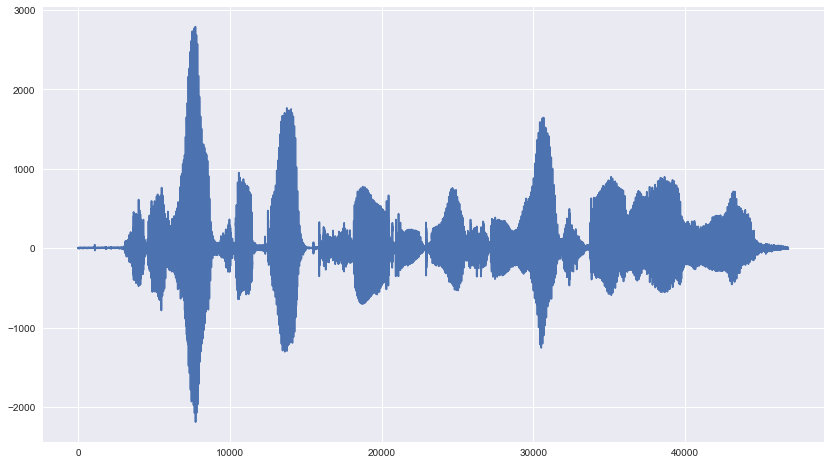

In [54]:
plt.figure(figsize=(14,8))
plt.plot(np.linspace(0,len(samples),len(samples)),samples) 
#np.linspace(): set up 3rd argument to sample_rate,otherwise default=50
plt.show()

# 2. Frame segmentation

**Reason of Frame**  : the samples can be divided into frames because that on short time scales the audio signal doesn't change much (when we say it doesn't change, we mean statistically i.e. statistically stationary, obviously the samples are constantly changing on even short time scales).

if the frame size is too short, we can't get reliable spectral estimate, if too large, signal changed too much in one frame

In [61]:
t_feed=10 #feed time
t_frame=20 #frame time
fs=sample_rate/1000 #sample_rate of each ms
L_value=np.int(fs*t_frame)
L_value

320

In [106]:
def frame_segment(samples):
    K_value=np.int((len(samples)-L_value)/(fs*t_feed))+1 #calculate the number of frames
    frame_set=[]
    for k in range(K_value):
        frame_set.append(samples[k*np.int(fs*t_feed):k*np.int(fs*t_feed)+L_value])#[0,n] contains 0~n-1
    return frame_set,K_value


In [107]:
frame_set,K_value=frame_segment(samples)

In [108]:
K_value

291

In [102]:
len(frame_set)

291

# 3. Voice activity detection

## Step 1:

try to figure out the noise signal power from the mixed signal power

In [214]:
mixed_power_set=[]
for k in range(K_value):
    if np.sum(np.float64((frame_set[k]))**2)<0:
        print(k)
    mixed_power_set.append(1/(L_value)*np.sum((np.float64(frame_set[k]))**2))#use np.float64 to avoid overflow encountered in long scalars



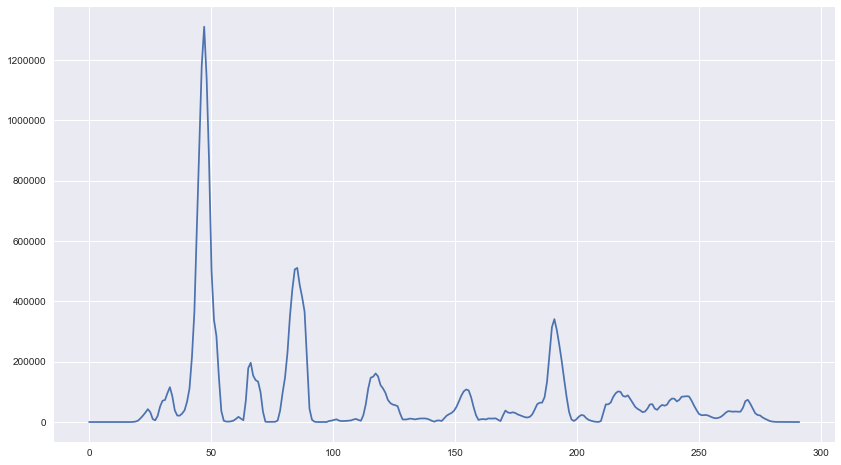

In [215]:
plt.figure(figsize=(14,8))
plt.plot(np.linspace(0,len(mixed_power_set),len(mixed_power_set)),mixed_power_set) 
#np.linspace(): set up 3rd argument to sample_rate,otherwise default=50
plt.show()

In [180]:
len(mixed_power_set)

291

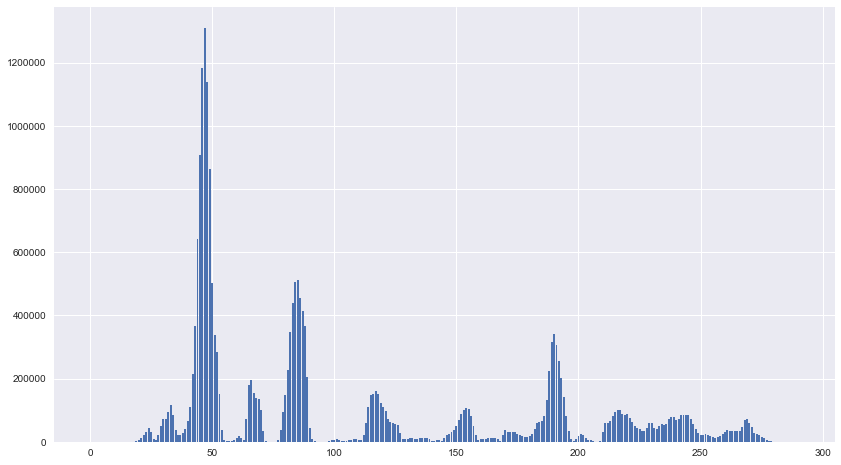

In [216]:
plt.figure(figsize=(14,8))
plt.bar(range(K_value),mixed_power_set)  #plt,bar(index,height(value))
plt.show()

## Step 2:

drop first $t_{n}$ samples becasue of silence

In [205]:
t_n=100
K_drop=np.int((t_n/t_feed)-1)

In [217]:
no_speech_set=frame_set[:K_drop]
noise_power_set=(1/K_drop)*np.sum(no_speech_set)

## Step 3

try to find a $\gamma$ as the threshold to satisfied that :
$$P(k)\lessgtr\gamma * P_{N}$$, only the frames containing speech should be used to train the classification model

In [232]:
gamma=2.0
mixed_power_set=pd.Series(mixed_power_set)

In [233]:
train_power_set=mixed_power_set.loc[mixed_power_set>gamma*noise_power_set]
train_power_set

20     4.705006e+03
21     1.237095e+04
22     2.132011e+04
23     3.150416e+04
24     4.276744e+04
25     3.249521e+04
26     9.907894e+03
27     5.694228e+03
28     2.051420e+04
29     5.152100e+04
30     7.066684e+04
31     7.304410e+04
32     9.584836e+04
33     1.155242e+05
34     8.502992e+04
35     3.882375e+04
36     2.155028e+04
37     2.113011e+04
38     2.818790e+04
39     3.900801e+04
40     6.719116e+04
41     1.108835e+05
42     2.148099e+05
43     3.651409e+05
44     6.425373e+05
45     9.071272e+05
46     1.181571e+06
47     1.310546e+06
48     1.139754e+06
49     8.624488e+05
           ...     
249    2.723986e+04
250    2.283999e+04
251    2.286285e+04
252    2.341776e+04
253    2.091774e+04
254    1.702419e+04
255    1.387281e+04
256    1.246491e+04
257    1.394038e+04
258    1.732054e+04
259    2.352315e+04
260    3.122717e+04
261    3.618738e+04
262    3.509283e+04
263    3.418768e+04
264    3.509950e+04
265    3.422540e+04
266    3.431995e+04
267    4.722658e+04


In [250]:
train_frame_set=[]
for index in train_power_set.index:
    train_frame_set.append(frame_set[index])

# 4. Feature extraction

The next step is to calculate the power spectrum of each frame. This is motivated by the human cochlea (an organ in the ear) which vibrates at different spots depending on the frequency of the incoming sounds. 

In [253]:
np.hamming(L_value)

array([ 0.08      ,  0.08008923,  0.08035687,  0.08080283,  0.08142693,
        0.08222892,  0.08320851,  0.0843653 ,  0.08569885,  0.08720865,
        0.08889409,  0.09075454,  0.09278928,  0.0949975 ,  0.09737835,
        0.09993092,  0.10265421,  0.10554716,  0.10860865,  0.11183749,
        0.11523244,  0.11879217,  0.12251531,  0.1264004 ,  0.13044595,
        0.13465037,  0.13901205,  0.14352929,  0.14820034,  0.15302337,
        0.15799654,  0.1631179 ,  0.16838546,  0.17379719,  0.17935098,
        0.18504469,  0.19087609,  0.19684294,  0.20294291,  0.20917363,
        0.2155327 ,  0.22201764,  0.22862594,  0.23535503,  0.24220231,
        0.24916511,  0.25624074,  0.26342646,  0.27071946,  0.27811694,
        0.285616  ,  0.29321375,  0.30090724,  0.30869349,  0.31656946,
        0.32453212,  0.33257836,  0.34070507,  0.34890909,  0.35718725,
        0.36553633,  0.37395308,  0.38243426,  0.39097656,  0.39957667,
        0.40823126,  0.41693696,  0.42569041,  0.4344882 ,  0.44